# Supervised Learning in Python 

If you don't have a proper hardware / software configuration you can use Colab: https://colab.research.google.com/notebooks/intro.ipynb?hl=nb
Many libraries are already installed (PyTorch, Tensorflow...)

## Perceptron

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import pandas as pd
import numpy as np

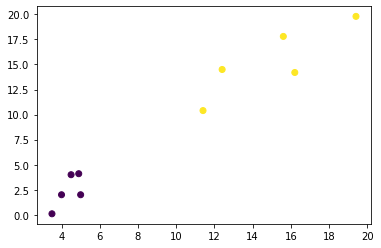

In [7]:
# Read data from file
data = pd.read_csv('perceptron-data.csv')
labels = torch.tensor(data['target'].values, dtype=torch.float32)
data = torch.tensor(data[['x', 'y']].values, dtype=torch.float32)
plt.scatter(data[:, 0], data[:, 1], c=labels)

Last accuracy: 100.0%


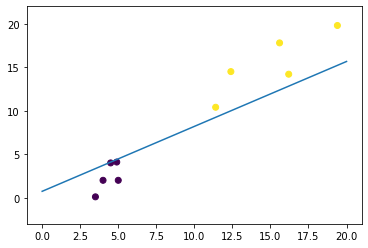

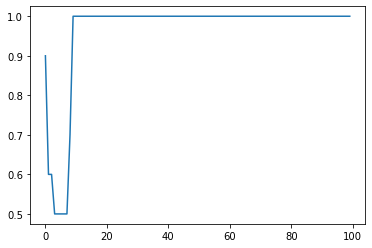

In [8]:
accuracies = []
epochs = 100
eta = 0.1

numpt = data.size(0)
inputDim = data.size(1)

weights = torch.randn(inputDim, dtype=torch.float32, requires_grad=True)
bias = torch.zeros(1, requires_grad=True)

with torch.no_grad():
    for epoch in range(epochs):
        total_accuracy = 0
        
        for idx in range(numpt):
            X = data[idx,:]
            y = labels[idx]
            
            # compute output and loss
            out = torch.add(torch.dot(weights, X), bias).item()
            out = 1 if out > 0 else 0
            if out == y:
                total_accuracy += 1
        
            weights += eta * (y - out) * X
            bias += eta * (y - out)        

        accuracies.append(total_accuracy / float(numpt))

print(f'Last accuracy: {accuracies[-1]*100}%')
# plot points, hyperplane and learning curve
plt.figure()
plt.scatter(data[:,0].numpy(), data[:,1].numpy(), c=labels.numpy())
xr = np.linspace(0, 20, 10)
yr = (-1 / weights[1].item()) * (weights[0].item() * xr  + bias.item())
plt.plot(xr, yr,'-')
plt.xlim(-1, 21)
plt.ylim(-3, 22)
plt.show()

plt.figure()
plt.plot(accuracies, '-')
plt.show()

## Multi Layer Perceptron (a.k.a. feedforward networks)

In [7]:
import torch.nn as nn
import torch.optim as optim

In [3]:
class MLP(nn.Module):
    def __init__(self, layers):

        super(MLP, self).__init__()

        assert len(layers) >= 2, "Layers must specify at least input and output size."

        mlp_layers = []
        for i in range(1, len(layers)):
            mlp_layers.append(nn.Linear(layers[i-1], layers[i], bias=True))
            mlp_layers.append(nn.ReLU())

        self.model = nn.Sequential(*mlp_layers)

    def forward(self, x):
        out = self.model(x)
        return out

In [4]:
# Read data from file
data = pd.read_csv('perceptron-data_notsep.csv')
labels = torch.tensor(data['target'].values).long() # transform labels from {-1, 1} to {0, 1}
data = torch.tensor(data[['x', 'y']].values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data, labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True, drop_last=True)
numpt = data.size(0)
inputDim = data.size(1)


Last accuracy: 100.0%


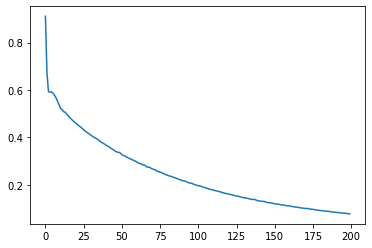

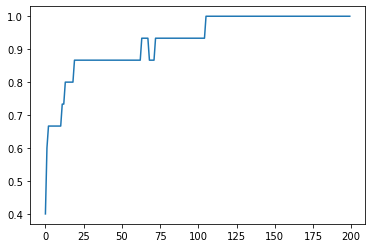

In [5]:
mlp = MLP([inputDim, 64, 2])
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 200

losses = []
accuracies = []
for epoch in range(epochs):
    total_loss, total_accuracy = 0, 0
    for x,y in dataloader:        
        optimizer.zero_grad()
        out = mlp(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            accuracy = (out.argmax(dim=1) == y).sum() / float(y.numel())
        total_loss += loss.item()
        total_accuracy += accuracy.item()
    losses.append(total_loss / float(len(dataloader)))
    accuracies.append(total_accuracy / float(len(dataloader)))


print(f"Last accuracy: {accuracies[-1]*100}%")
plt.figure()
plt.plot(losses, '-')
plt.show()
plt.figure()
plt.plot(accuracies, '-')
plt.show()

## Some popular metrics (and combinations of them)

In [26]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve

In [12]:
# F1
y_true = np.random.randint(0, 5, (1000,))
y_pred = np.random.randint(0, 5, (1000,))
f1_score(y_true, y_pred, average='macro')

0.18714907362393426

In [30]:
# Confusion matrix
y_true = np.random.randint(0, 5, (1000,))
y_pred = np.random.randint(0, 5, (1000,))
confusion_matrix(y_true, y_pred, normalize='all')

array([[0.04 , 0.04 , 0.039, 0.044, 0.038],
       [0.04 , 0.041, 0.041, 0.033, 0.035],
       [0.04 , 0.04 , 0.049, 0.041, 0.038],
       [0.036, 0.042, 0.042, 0.041, 0.045],
       [0.03 , 0.043, 0.043, 0.032, 0.047]])

In [24]:
# P-R curve
y_true = np.random.randint(0, 2, (10,))
y_pred = np.random.random((10,))
p, r, t = precision_recall_curve(y_true, y_pred)
print(p)
print(r)
print(t)

[0.66666667 0.6        0.75       0.66666667 1.         1.
 1.        ]
[1.   0.75 0.75 0.5  0.5  0.25 0.  ]
[0.52783233 0.5768105  0.73339931 0.86503823 0.90438018 0.9772652 ]


In [31]:
# what about ROC curve? Try it out!